## Redes Neurais Convolucionais

**Classificando dígitos escritos a mão**

Para exemplificar o funcionamento de uma rede neural convolucional, vamos utilizar o dataset MNIST.

Esse dataset é disponibilizado pelo Keras e consistem em imagens de treinamento e imagens de teste para classificar dígitos escritos a mão que variam entre 0 a 9.

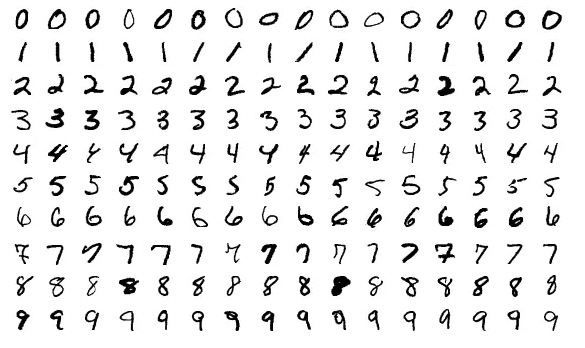

### Importando a base de dados

In [ ]:
#!pip3 install --upgrade "tensorflow==1.15"

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython.display import Image

In [ ]:
# Caso a importação abaixo der erro, tente este código abaixo:

#tf.keras.datasets.mnist.load_data(
    #path='mnist.npz'
#)

Importando a base e separando os dados em treino e teste:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28) #assert para verificar se uma condição é verdadeira
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [ ]:
x_train.shape

**Vamos analisar as imagens:**

In [ ]:
print(x_test[10]) #analisando a posição número 10

Cada imagem pode ser vista como um vetor de **28x28** = **784** números, sendo cada uma um ponto no espaço 784-dimensional. Cada posição desse vetor, representa uma característica da imagem. 

Observe os dados variam entre *0 a 1*, sendo esses valores os pixels das imagens. 

Vamos desenhar as imagens para entender melhor:

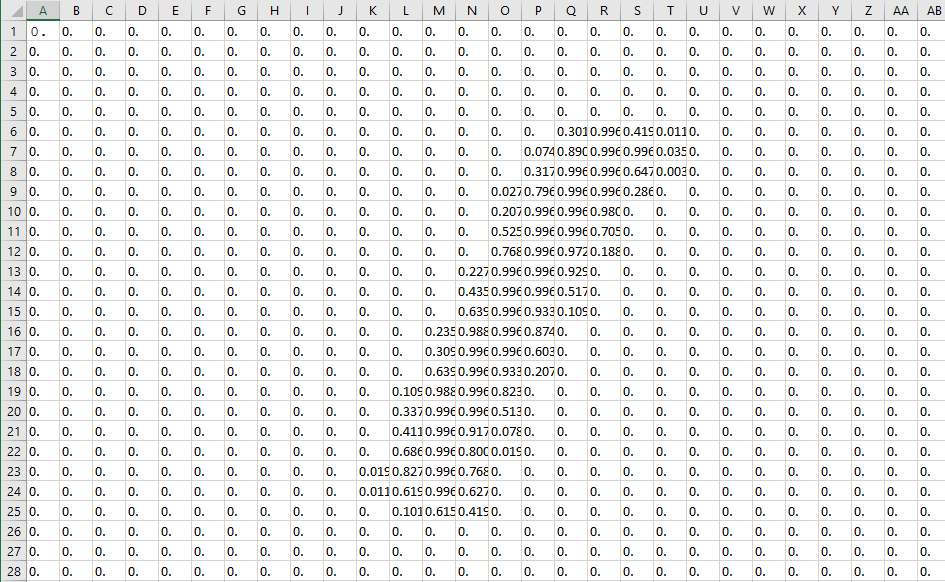

In [ ]:
%matplotlib inline   
x = x_test[10]              #acessando a posição 10
x_img = x.reshape([28, 28]) #transformando a imagem em seu formato 28x28
plt.gray()                  #plot em escalas de cinza
plt.imshow(x_img)           #mostrando a imagem

Podemos observar que o vetor da posição 10 representa o número "0".

In [ ]:
y = y_test[10] #acessando a label target da posição 10
print(y)

Nossa label classificadora pode nos afirmar que essa posição foi classificada como número 0.

## Padronizando os dados

As redes neurais têm muito mais facilidade para convergir (encontrar o melhor mínimo local) quando trabalham com valores que não variam muito em escala. 

É uma prática comum dimensionar cada entrada para caber em um pequeno intervalo como 0 a 1 ou -1 a 1.

## Aplicando a padronização

In [ ]:
train_data = x_train.reshape(x_train.shape[0],28,28,1) # achatando a matriz em um único array
test_data  = x_test.reshape(x_test.shape[0],28,28,1)

In [ ]:
#Normalizando valores entre 0 e 1:
train_data = train_data/255.0 #caso precisar normalizar os dados
test_data  = test_data/255.0  #caso precisar normalizar os dados


In [ ]:
train_data.shape # o "1" mostra o número de canais de cor.(1 é escala de cinza)

In [ ]:
test_data.shape

Identificado a padronização:

In [ ]:
train_data[0].min(), test_data[0].max()

Observe que antes nosso mínimo e máximo variava de 0 a 255 (pixels).

# Inciando a construção do modelo:

**Sequencial:** O Keras vai adicionando no modelo as camadas da rede.

**Camadas(Layers):** O principal objetivo dessa camada na rede é extrair as informações (características) de cada atributo passado como entrada de dados (imagens).

*Componetes:*

* **Conv2D:** Camada com kernels (filtros) que percorrem a imagem extraindo caracterísitcas (mapas de caracteísticas).

* **MaxPooling2D:** Camada que reduz a dimensionalidade dos mapas de características 2D.

* **Flatten:** Transforma o formato da imagem para um array de uma uma única dimensão (de 28 * 28 = 784 pixels). Ou seja, a imagem deixa de ser 2D para 1D.

* **Dense**: Camadas neurais onde são parametrizados os números totais de neurônios que seram treinados na rede (também podemos chamar de fully connected). Na camada Dense, também temos as funções de ativação com a finalidade de promover um resultado probabilístico referente a classificação dos dados.

* **Dropout:** Camada usa durante treino que descarta aleatoriamente um percentual de conexões (reduz overfitting)

In [ ]:
model = keras.Sequential([
# CNN
    layers.Conv2D(32,             #número de neurônios (filtros)
                  (3,3),          #kernel_size é a matriz que realiza o filtro
                  strides=(2, 2), #especifica quantos pixels o filtro (kernel)se movem.
                  padding="same", #para evitar a redução da resolução espacial, o padding same adiciona pixels de preenchimento (geralmente zeros) ao redor da imagem.
                  activation='relu', #função de ativação
                  input_shape=(28, 28,1)), #entrada da rede
    
    layers.Conv2D(16, 
                  (3,3), 
                  strides=(2, 2), 
                  padding="same", 
                  activation='relu', 
                  input_shape=(28, 28,1)), 
    
    layers.MaxPooling2D((2,2)), #reduzir as dimensões espaciais do volume de saída.
    
    layers.Dropout(0.2), #regularização da rede.


# Padding = "valid"significa sem preenchimento. 
# Padding = "same" resulta no preenchimento com zeros uniformemente à esquerda/direita ou para cima/para baixo da entrada.

    #Classificador
    layers.Flatten(),#As camadas achatadas são usadas quando você obtém uma saída multidimensional e deseja torná-la linear para passá-la para uma camada densa
    layers.Dense(128, 
                 activation='sigmoid'),
    keras.layers.Dense(10, 
                       activation='sigmoid') #array de 10 probabilidades, cuja soma resulta em 1. Regressão que retorna probabilidades.
])

model.summary()

**Compilando o modelo**

Antes de iniciar o treinamento da rede, vamos adicionar mais alguns parâmetros:

* **Função loss:** Mede a precisão do modelo. (Cálculo do erro)
* **Optimizer:**  Otimizador do modelo, responsável pela atualização dos dados com base no resultado da função loss.
* **Métricas:** Utilizadas para monitoramento do resultado da rede. (A famosa acurácia).

In [ ]:
model.compile(optimizer='adam',                       #adaptive moment estimation - descida do gradiente.
              loss='sparse_categorical_crossentropy', #mede quão precisa o modelo é durante o treinamento. Queremos minimizar a função para guiar o modelo para a direção certa.
              metrics=['accuracy'])                   #acurácia da rede

## Treinando o modelo

Chegamos ao treinamento do modelo, nessa etapa passamos para o modelo.fit a nossa base de treino de imagens + nossas labels (preditores) e a quantidade de epochs que irá ser executada no modelo.

In [ ]:
epochs_hist = model.fit(train_data, y_train, epochs=8)

In [ ]:
epochs_hist_test = model.fit(test_data, y_test, epochs=8)

In [ ]:
import pandas as pd

history_df = pd.DataFrame(epochs_hist.history)

history_df['loss'].plot();      #linha azul
history_df['accuracy'].plot();  #linha laranja
plt.legend()

In [ ]:
model.summary() #resumo do modelo executado

## Fazendo as predições

In [ ]:
def probabilidade(data, posicao):
  result = model.predict(np.array([data[posicao]]))
  predicted_value = np.argmax(result)                     #valor máximo preditivo dentro do vetor de porbabilidades
  print("Valor predito:", predicted_value)                #valor predito
  print("Probabilidades:", result)                        #resultado em probabilidade

In [ ]:
probabilidade(test_data, 3)

In [ ]:
image = test_data[3].reshape(28,28)
plt.imshow(image)